<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [6]:
keys = ['contacts', 'querents', 'patients_summary', 'discharges_summary']

In [7]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,discharges_count,datetime
2020-01-24 17:00:00+09:00,0,0,2,0,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,0,0,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...,...
2020-10-22 17:00:00+09:00,362,1140,185,0,2020-10-22 17:00:00+09:00
2020-10-23 17:00:00+09:00,335,1085,186,0,2020-10-23 17:00:00+09:00
2020-10-24 17:00:00+09:00,341,716,203,0,2020-10-24 17:00:00+09:00
2020-10-25 17:00:00+09:00,336,718,124,0,2020-10-25 17:00:00+09:00


In [8]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum
2020-10-22 17:00:00+09:00,362,1140,185,0,2020-10-22 17:00:00+09:00,344.857143,2414.0,1040.714286,7285.0,156.714286,1097.0,0.0,0.0
2020-10-23 17:00:00+09:00,335,1085,186,0,2020-10-23 17:00:00+09:00,343.142857,2402.0,1032.571429,7228.0,157.142857,1100.0,0.0,0.0
2020-10-24 17:00:00+09:00,341,716,203,0,2020-10-24 17:00:00+09:00,346.428571,2425.0,1024.571429,7172.0,152.571429,1068.0,0.0,0.0
2020-10-25 17:00:00+09:00,336,718,124,0,2020-10-25 17:00:00+09:00,344.857143,2414.0,1018.571429,7130.0,151.428571,1060.0,0.0,0.0
2020-10-26 17:00:00+09:00,0,0,102,0,2020-10-26 17:00:00+09:00,290.857143,2036.0,827.714286,5794.0,154.857143,1084.0,0.0,0.0


In [9]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day
2020-10-12 17:00:00+09:00,527,2013,78,0,2020-10-12 17:00:00+09:00,452.571429,3168.0,1332.714286,9329.0,177.285714,1241.0,0.0,0.0,'20w42,Mon
2020-10-13 17:00:00+09:00,397,1271,166,0,2020-10-13 17:00:00+09:00,443.571429,3105.0,1316.428571,9215.0,175.714286,1230.0,0.0,0.0,'20w42,Tue
2020-10-14 17:00:00+09:00,391,1176,177,0,2020-10-14 17:00:00+09:00,431.571429,3021.0,1284.000000,8988.0,180.857143,1266.0,0.0,0.0,'20w42,Wed
2020-10-15 17:00:00+09:00,354,1158,284,0,2020-10-15 17:00:00+09:00,423.285714,2963.0,1262.857143,8840.0,186.000000,1302.0,0.0,0.0,'20w42,Thu
2020-10-16 17:00:00+09:00,347,1142,183,0,2020-10-16 17:00:00+09:00,417.142857,2920.0,1239.285714,8675.0,183.142857,1282.0,0.0,0.0,'20w42,Fri
2020-10-17 17:00:00+09:00,318,772,235,0,2020-10-17 17:00:00+09:00,398.428571,2789.0,1213.714286,8496.0,181.285714,1269.0,0.0,0.0,'20w42,Sat
2020-10-18 17:00:00+09:00,347,760,132,0,2020-10-18 17:00:00+09:00,383.000000,2681.0,1184.571429,8292.0,179.285714,1255.0,0.0,0.0,'20w42,Sun
2020-10-19 17:00:00+09:00,378,1336,78,0,2020-10-19 17:00:00+09:00,361.714286,2532.0,1087.857143,7615.0,179.285714,1255.0,0.0,0.0,'20w43,Mon
2020-10-20 17:00:00+09:00,328,1067,139,0,2020-10-20 17:00:00+09:00,351.857143,2463.0,1058.714286,7411.0,175.428571,1228.0,0.0,0.0,'20w43,Tue
2020-10-21 17:00:00+09:00,334,1068,145,0,2020-10-21 17:00:00+09:00,343.714286,2406.0,1043.285714,7303.0,170.857143,1196.0,0.0,0.0,'20w43,Wed


In [10]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-10-04 17:00:00+09:00,175.285714,1227
2020-10-11 17:00:00+09:00,175.571429,1229
2020-10-18 17:00:00+09:00,179.285714,1255
2020-10-25 17:00:00+09:00,151.428571,1060
2020-10-26 17:00:00+09:00,102.000000,102


In [12]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-10-12 17:00:00+09:00,527,2013,78,0,2020-10-12 17:00:00+09:00,452.571429,3168.0,1332.714286,9329.0,177.285714,1241.0,0.0,0.0,'20w42,Mon,NaN,NaN
2020-10-13 17:00:00+09:00,397,1271,166,0,2020-10-13 17:00:00+09:00,443.571429,3105.0,1316.428571,9215.0,175.714286,1230.0,0.0,0.0,'20w42,Tue,NaN,NaN
2020-10-14 17:00:00+09:00,391,1176,177,0,2020-10-14 17:00:00+09:00,431.571429,3021.0,1284.000000,8988.0,180.857143,1266.0,0.0,0.0,'20w42,Wed,NaN,NaN
2020-10-15 17:00:00+09:00,354,1158,284,0,2020-10-15 17:00:00+09:00,423.285714,2963.0,1262.857143,8840.0,186.000000,1302.0,0.0,0.0,'20w42,Thu,NaN,NaN
2020-10-16 17:00:00+09:00,347,1142,183,0,2020-10-16 17:00:00+09:00,417.142857,2920.0,1239.285714,8675.0,183.142857,1282.0,0.0,0.0,'20w42,Fri,NaN,NaN
2020-10-17 17:00:00+09:00,318,772,235,0,2020-10-17 17:00:00+09:00,398.428571,2789.0,1213.714286,8496.0,181.285714,1269.0,0.0,0.0,'20w42,Sat,NaN,NaN
2020-10-18 17:00:00+09:00,347,760,132,0,2020-10-18 17:00:00+09:00,383.000000,2681.0,1184.571429,8292.0,179.285714,1255.0,0.0,0.0,'20w42,Sun,179.285714,1255.0
2020-10-19 17:00:00+09:00,378,1336,78,0,2020-10-19 17:00:00+09:00,361.714286,2532.0,1087.857143,7615.0,179.285714,1255.0,0.0,0.0,'20w43,Mon,NaN,NaN
2020-10-20 17:00:00+09:00,328,1067,139,0,2020-10-20 17:00:00+09:00,351.857143,2463.0,1058.714286,7411.0,175.428571,1228.0,0.0,0.0,'20w43,Tue,NaN,NaN
2020-10-21 17:00:00+09:00,334,1068,145,0,2020-10-21 17:00:00+09:00,343.714286,2406.0,1043.285714,7303.0,170.857143,1196.0,0.0,0.0,'20w43,Wed,NaN,NaN


### グラフ出力

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

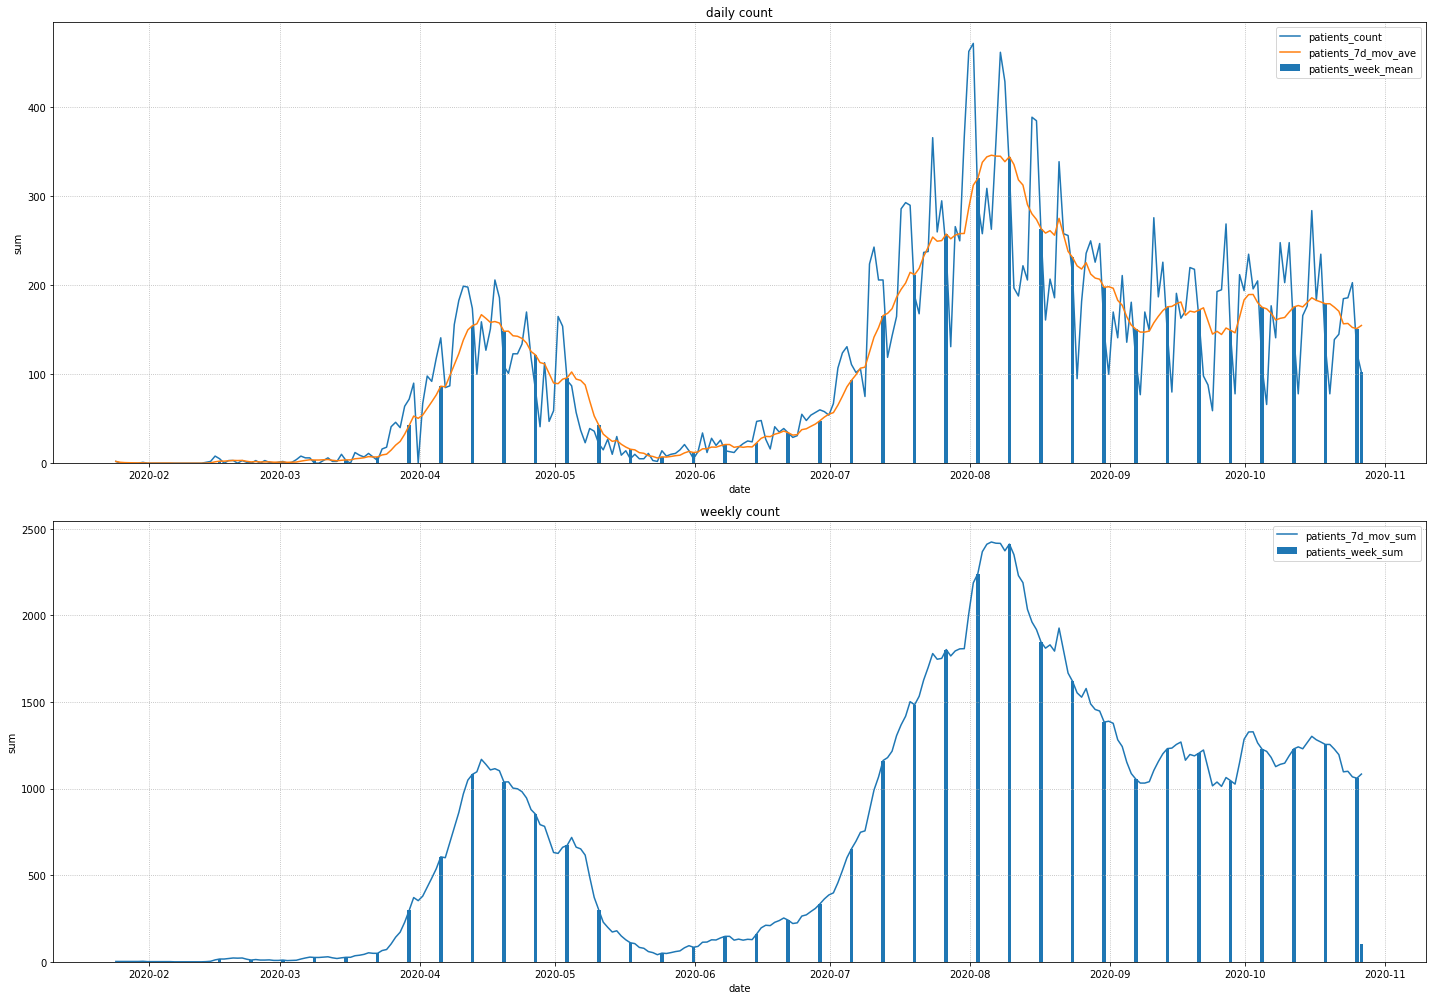

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
262,1.602490e+09,2020,10,12,0,1,0,0,0,0,0,262,0,188,527,452.571429,3168.0,2013,1332.714286,9329.0,78,177.285714,1241.0,0,0.0,0.0
263,1.602576e+09,2020,10,13,0,0,0,0,0,1,0,263,0,189,397,443.571429,3105.0,1271,1316.428571,9215.0,166,175.714286,1230.0,0,0.0,0.0
264,1.602662e+09,2020,10,14,0,0,0,0,0,0,1,264,0,190,391,431.571429,3021.0,1176,1284.000000,8988.0,177,180.857143,1266.0,0,0.0,0.0
265,1.602749e+09,2020,10,15,0,0,0,0,1,0,0,265,0,191,354,423.285714,2963.0,1158,1262.857143,8840.0,284,186.000000,1302.0,0,0.0,0.0
266,1.602835e+09,2020,10,16,1,0,0,0,0,0,0,266,0,192,347,417.142857,2920.0,1142,1239.285714,8675.0,183,183.142857,1282.0,0,0.0,0.0
267,1.602922e+09,2020,10,17,0,0,1,0,0,0,0,267,0,193,318,398.428571,2789.0,772,1213.714286,8496.0,235,181.285714,1269.0,0,0.0,0.0
268,1.603008e+09,2020,10,18,0,0,0,1,0,0,0,268,0,194,347,383.000000,2681.0,760,1184.571429,8292.0,132,179.285714,1255.0,0,0.0,0.0
269,1.603094e+09,2020,10,19,0,1,0,0,0,0,0,269,0,195,378,361.714286,2532.0,1336,1087.857143,7615.0,78,179.285714,1255.0,0,0.0,0.0
270,1.603181e+09,2020,10,20,0,0,0,0,0,1,0,270,0,196,328,351.857143,2463.0,1067,1058.714286,7411.0,139,175.428571,1228.0,0,0.0,0.0
271,1.603267e+09,2020,10,21,0,0,0,0,0,0,1,271,0,197,334,343.714286,2406.0,1068,1043.285714,7303.0,145,170.857143,1196.0,0,0.0,0.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              277 non-null    float64
 1   year                   277 non-null    int64  
 2   month                  277 non-null    int64  
 3   day                    277 non-null    int64  
 4   Fri                    277 non-null    uint8  
 5   Mon                    277 non-null    uint8  
 6   Sat                    277 non-null    uint8  
 7   Sun                    277 non-null    uint8  
 8   Thu                    277 non-null    uint8  
 9   Tue                    277 non-null    uint8  
 10  Wed                    277 non-null    uint8  
 11  passed                 277 non-null    int64  
 12  emergency              277 non-null    int64  
 13  em_passed              277 non-null    int64  
 14  contacts_count         277 non-null    int64  
 15  contac

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
count,2.770000e+02,277.0,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.00000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.0,277.0,277.0
mean,1.591776e+09,2020.0,5.808664,15.830325,0.144404,0.144404,0.144404,0.144404,0.140794,0.140794,0.140794,138.00000,0.176895,74.018051,795.631769,792.999914,5550.985560,1310.707581,1303.973698,9127.815884,108.761733,107.165704,750.079422,0.0,0.0,0.0
std,6.921264e+06,0.0,2.640857,8.818012,0.352135,0.352135,0.352135,0.352135,0.348439,0.348439,0.348439,80.10722,0.382271,67.306160,496.284983,482.571562,3378.023657,779.104734,595.993090,4171.951632,106.698924,97.767009,684.456910,0.0,0.0,0.0
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,1.585814e+09,2020.0,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.00000,0.000000,0.000000,465.000000,472.714286,3309.000000,790.000000,992.428571,6947.000000,11.000000,11.142857,78.000000,0.0,0.0,0.0
50%,1.591776e+09,2020.0,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,138.00000,0.000000,64.000000,650.000000,660.142857,4621.000000,1306.000000,1298.857143,9092.000000,85.000000,94.571429,662.000000,0.0,0.0,0.0
75%,1.597738e+09,2020.0,8.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,207.00000,0.000000,133.000000,1015.000000,1018.142857,7127.000000,1798.000000,1737.000000,12159.000000,186.000000,175.285714,1227.000000,0.0,0.0,0.0
max,1.603699e+09,2020.0,10.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,276.00000,1.000000,202.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,472.000000,346.285714,2424.000000,0.0,0.0,0.0


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
timestamp,1.000000e+00,NaN,0.993967,0.011884,-0.007707,0.007707,-0.002569,0.002569,0.005062,-0.005062,-1.049399e-18,1.000000e+00,-0.231902,0.978228,0.046158,0.099836,0.099842,0.409193,0.597723,0.597723,0.650445,0.722532,0.722642,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,9.939666e-01,NaN,1.000000,-0.097708,-0.009143,0.006442,-0.001350,0.002546,0.005757,-0.006055,1.819491e-03,9.939666e-01,-0.228349,0.970832,0.051589,0.103281,0.103288,0.412446,0.603639,0.603639,0.652310,0.722240,0.722362,NaN,NaN,NaN
day,1.188433e-02,NaN,-0.097708,1.000000,0.013754,0.011420,-0.011917,0.000918,-0.006347,0.008982,-1.696030e-02,1.188433e-02,-0.007186,0.017910,-0.028838,-0.011651,-0.011657,-0.033817,-0.062459,-0.062459,-0.043165,-0.028162,-0.028279,NaN,NaN,NaN
Fri,-7.706564e-03,NaN,-0.009143,0.013754,1.000000,-0.168776,-0.168776,-0.168776,-0.166303,-0.166303,-1.663028e-01,-7.706564e-03,-0.002041,-0.004849,-0.019784,-0.007088,-0.007086,0.064483,-0.008584,-0.008584,0.094265,-0.004456,-0.004588,NaN,NaN,NaN
Mon,7.706564e-03,NaN,0.006442,0.011420,-0.168776,1.000000,-0.168776,-0.168776,-0.166303,-0.166303,-1.663028e-01,7.706564e-03,-0.002041,0.008450,0.040899,-0.005026,-0.005024,0.268734,-0.005048,-0.005048,-0.158676,0.001836,0.001861,NaN,NaN,NaN
Sat,-2.568855e-03,NaN,-0.001350,-0.011917,-0.168776,-0.168776,1.000000,-0.168776,-0.166303,-0.166303,-1.663028e-01,-2.568855e-03,-0.002041,-0.000416,0.034244,-0.006049,-0.006047,-0.326018,-0.006818,-0.006818,0.118566,-0.001509,-0.001536,NaN,NaN,NaN
Sun,2.568855e-03,NaN,0.002546,0.000918,-0.168776,-0.168776,-0.168776,1.000000,-0.166303,-0.166303,-1.663028e-01,2.568855e-03,-0.002041,0.004017,-0.014228,-0.005026,-0.005024,-0.300146,-0.005048,-0.005048,-0.038714,0.000320,0.000328,NaN,NaN,NaN
Thu,5.062412e-03,NaN,0.005757,-0.006347,-0.166303,-0.166303,-0.166303,-0.166303,1.000000,-0.163866,-1.638655e-01,5.062412e-03,0.002750,0.002054,-0.002779,0.008893,0.008895,0.088880,0.011371,0.011371,0.095047,0.003886,0.003933,NaN,NaN,NaN
Tue,-5.062412e-03,NaN,-0.006055,0.008982,-0.166303,-0.166303,-0.166303,-0.166303,-0.163866,1.000000,-1.638655e-01,-5.062412e-03,0.002750,-0.006906,-0.025533,0.006751,0.006752,0.120938,0.005868,0.005868,-0.050161,-0.001116,-0.001080,NaN,NaN,NaN


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum', 'discharges_count',
       'discharges_7d_mov_ave', 'discharges_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          'discharges_7d_mov_ave', 'discharges_7d_mov_sum'], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,2,2.000000,2.0,0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,0,1.000000,2.0,0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0,0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0,0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,1.603354e+09,0,0,0,0,1,0,0,272,0,198,362,1140,185,156.714286,1097.0,0
273,1.603440e+09,1,0,0,0,0,0,0,273,0,199,335,1085,186,157.142857,1100.0,0
274,1.603526e+09,0,0,1,0,0,0,0,274,0,200,341,716,203,152.571429,1068.0,0
275,1.603613e+09,0,0,0,1,0,0,0,275,0,201,336,718,124,151.428571,1060.0,0


In [26]:
import seaborn as sns

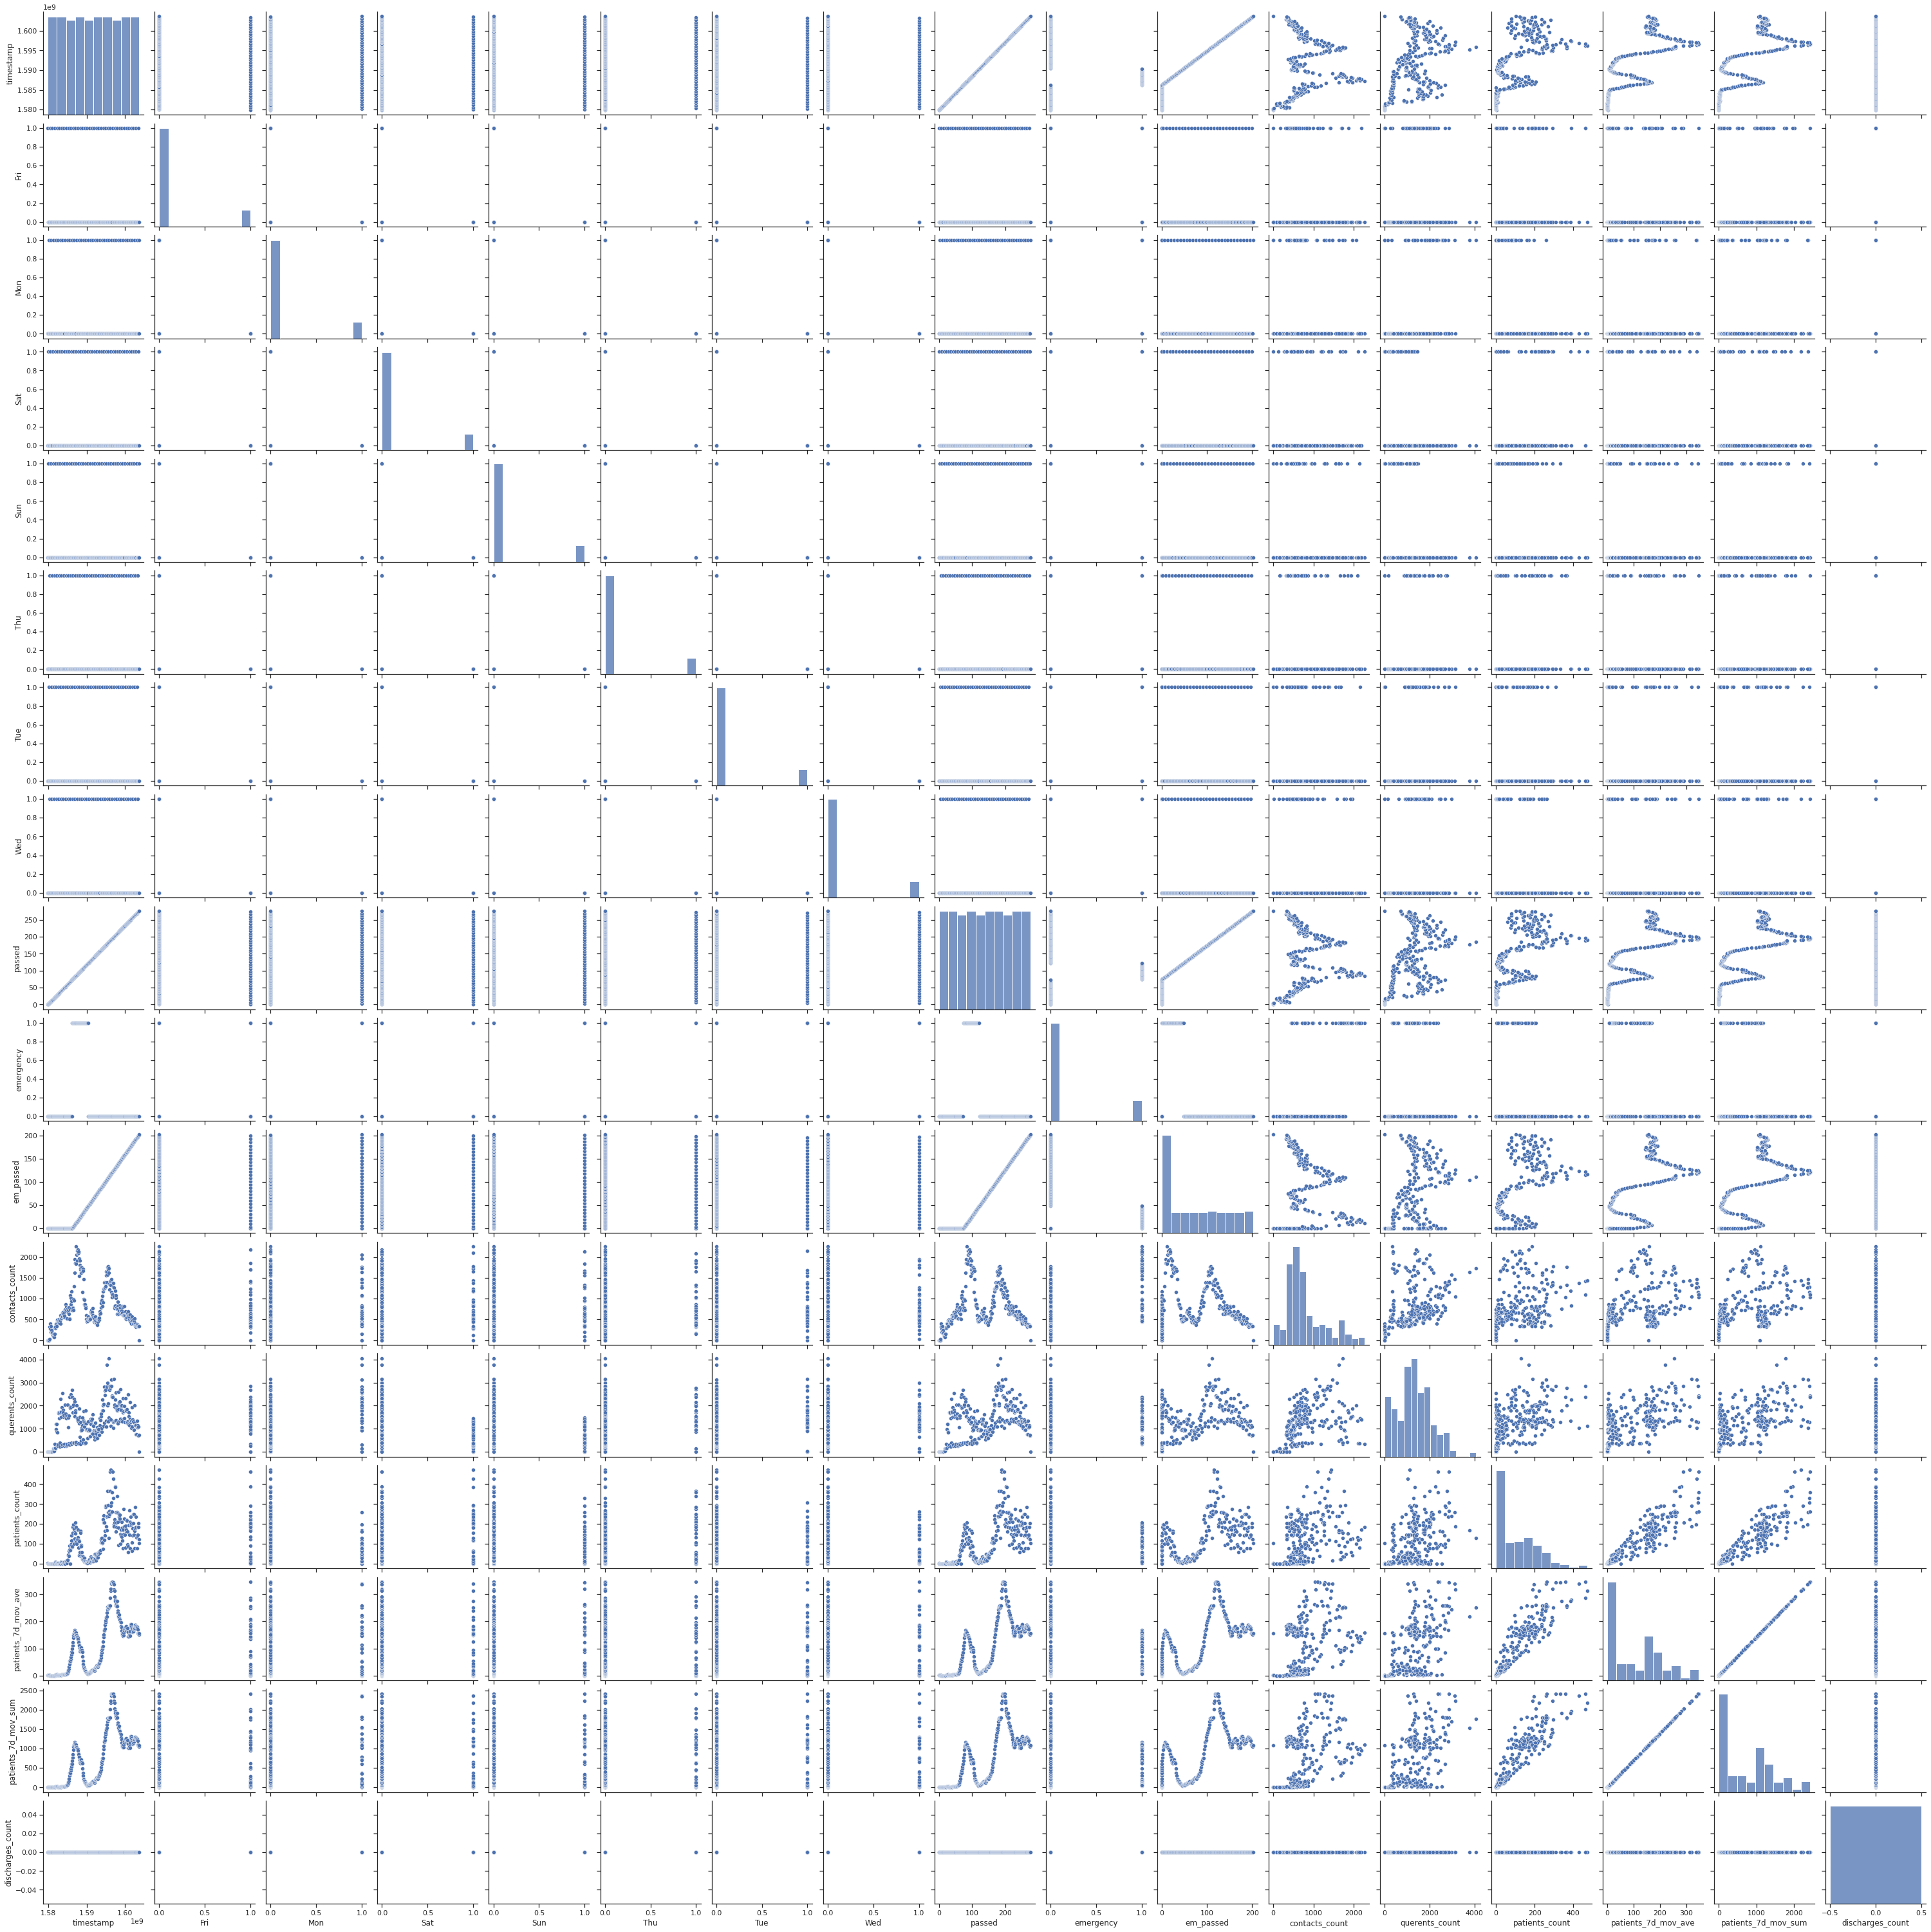

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [28]:
!python -V

Python 3.6.9
